# Project 1

For your first project you are going to go through each of the following functions and optimize in terms of memory and speed. You can import any libraries and perform any code transformations but the end result must be equal in order to be correct.

I recommend that you create a separate notebook or open an IDE and experiment there. Then come back to this notebook and write your answer. Each function has a cell with the original function, another one for your solution, and a profiling and correctness checker. The final submission will be this notebook plus a consecutive run in your PC (restart, run all and save as html) and another run on your Jetson Nano. You will submit all three files on Canvas.

The first cell is used to import the libraries we need to run these functions, the second cell will be for your libraries

In [ ]:
import numpy as np
import ctypes
import math
import time
from scipy import misc,ndimage
import matplotlib.pyplot as plt
from PIL import Image
from numba import jit,prange
import requests
from io import BytesIO
!pip install opencv-python
!pip install memory_profiler
import cv2
import numba as nb
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [ ]:
url1="http://getwallpapers.com/wallpaper/full/c/a/7/1235918-3000-x-3000-hd-wallpapers-3000x2000-for-hd-1080p.jpg"
url2="http://getwallpapers.com/wallpaper/full/c/4/1/1235927-3000-x-3000-hd-wallpapers-3000x2000-screen.jpg"
response1 = requests.get(url1)
response2 = requests.get(url2)

### These will be used as input arrays, they are all images transformed to numpy arrays
#A = Image.open('nature.jpg')
# convert image to numpy array
A = Image.open(BytesIO(response1.content))
A = np.asarray(A)/255
A = np.mean(A, axis=2)*255

#B = Image.open('sun.jpg')
# convert image to numpy array
B = Image.open(BytesIO(response2.content))
B = np.asarray(B)/255
B = np.mean(B, axis=2)*255
C=np.random.rand(A.shape[0],A.shape[1])*255




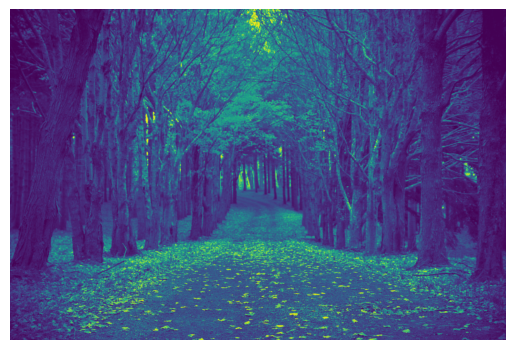

In [ ]:
### Verify the images are there and they are grayscale

plt.axis('off')
plt.imshow(A)
plt.show()

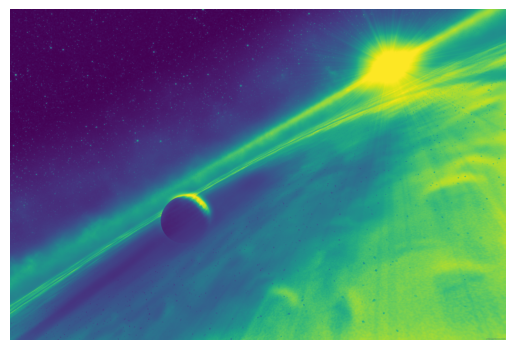

In [ ]:
plt.axis('off')
plt.imshow(B)
plt.show()

## Loop 1

In [ ]:
def loop1(A,B):
    a=np.copy(A)
    b=np.copy(B)

    for j in range (1,a.shape[0]-1):
        for i in range (1,a.shape[1]-1):
            a[j,i] = a[j - 1,i] + b[j,i];
            b[j,i] = b[j,i]**2

    return a,b




In [ ]:
x,y=loop1(A,B)

In [ ]:
%%timeit
loop1(A,B)

6.39 s ± 762 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%memit loop1(A,B)

peak memory: 559.22 MiB, increment: 91.64 MiB


In [ ]:
import numba as nb

@nb.njit
def loop1_sol(A, B):
    a = A.copy()
    b = B.copy()

    for j in range(1, a.shape[0]-1):
        for i in range(1, a.shape[1]-1):
            a[j, i] = a[j - 1, i] + b[j, i]
            b[j, i] = b[j, i] ** 2
    return a,b

In [ ]:
x1,y1=loop1_sol(A,B)

In [ ]:
%%timeit
loop1_sol(A,B)

109 ms ± 20.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%memit loop1_sol(A,B)

peak memory: 690.02 MiB, increment: 88.95 MiB


In [ ]:
##### If output is false, then your solution is incorrect

print(np.allclose(x,x1))
print(np.allclose(y,y1))


True
True


In [ ]:
##### Cleanup, get rid of all the objects we don't need anymore
del x,y,x1,y1

## Loop 2

In [ ]:
def loop2(A, B, C):
    a=np.copy(A)
    b=np.copy(B)


    for j in range (1,a.shape[0]-1):
        for i in range (1,a.shape[1]-1):
            a[j][i] = a[j-1][i] + C[j][i]
        for i in range (1,b.shape[1]-1):
            b[j][i] = b[j][i-1] + C[j][i]


    return a, b

In [ ]:
x,y = loop2(A,B,C)

In [ ]:
%%timeit
loop2(A,B,C)

11.6 s ± 760 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%memit loop2(A,B,C)

peak memory: 611.59 MiB, increment: 91.59 MiB


In [ ]:
import numba as nb

@nb.njit
def loop2_sol(A, B, C):
    a=np.copy(A)
    b=np.copy(B)

    #### Your code
    for j in range (1,a.shape[0]-1):
        c = C[j]
        for i in range (1,a.shape[1]-1):
            a[j][i] = a[j-1][i] + c[i]
        for i in range (1,b.shape[1]-1):
            b[j][i] = b[j][i-1] + c[i]


    return a, b

In [ ]:
x1,y1=loop2_sol(A,B,C)

In [ ]:
%%timeit
loop2_sol(A,B,C)

127 ms ± 25.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%memit loop2_sol(A,B,C)

peak memory: 611.97 MiB, increment: 0.11 MiB


In [ ]:
##### If output is false, then your solution is incorrect
print(np.allclose(x,x1))
print(np.allclose(y,y1))

True
True


In [ ]:
##### Cleanup, get rid of all the objects we don't need anymore
del x,y,x1,y1

## Matrix multiplication

In [ ]:

# SGEMM Form => C := alpha*A*B + beta*C,
# We create new variable because the images are too big
Am=np.random.rand(100,500)
Bm=np.random.rand(500,250)
Dm=np.random.rand(100,250)
# alpha and beta are constant floating point values, reuse them for your solution
alpha = 1.5
beta = 1.2

def sgemm_manual (alpha,A, B, beta, D):

    d=np.copy(D)
    for i in range(d.shape[0]):
        for j in range(d.shape[1]):
            d[i,j] *= beta
        for k in range(A.shape[1]):
            for j in range(d.shape[1]):
                d[i,j] += alpha * A[i,k] * B[k,j]
    return d


In [ ]:
x=sgemm_manual (alpha,Am, Bm, beta, Dm)

In [ ]:
%%timeit
sgemm_manual (alpha,Am, Bm, beta, Dm)

10.4 s ± 516 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:

%mprun sgemm_manual (alpha,Am, Bm, beta, Dm)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.11/dist-packages/memory_profiler.py", line 847, in enable
    sys.settrace(self.trace_memory_usage)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.11/dist-packages/memory_profiler.py", line 850, in disable
    sys.settrace(self._original_trace_function)



In [ ]:
@nb.njit()
def sgemm_solution (alpha,A, B, beta, D):
    d=np.copy(D)
    d = (beta*d)+(alpha*np.dot(A,B))
    return d

In [ ]:
x1=sgemm_solution (alpha,Am, Bm, beta, Dm)

In [ ]:
%%timeit
sgemm_solution (alpha,Am, Bm, beta, Dm)

1.33 ms ± 632 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
%memit sgemm_solution (alpha,Am, Bm, beta, Dm)

peak memory: 505.59 MiB, increment: 0.00 MiB


In [ ]:
##### If output is false, then your solution is incorrect
print(np.allclose(x,x1))

True


In [ ]:
##### Cleanup, get rid of all the objects we don't need anymore
del x,x1

## Laplacian operator

In [ ]:
def Laplacian_Operator(A):
    x = A.shape[0]
    y = A.shape[1]
    laplacian = np.empty((x - 2, y - 2))
    for i in range(1, x - 1):
        for j in range(1, y - 1):
            laplacian[i-1, j-1] = np.abs(A[i-1, j] + A[i+1, j] + A[i, j-1] + A[i, j+1] - 4*A[i, j]) > 0.05
    return laplacian


In [ ]:
LO=Laplacian_Operator(A)

In [ ]:
%%timeit
Laplacian_Operator(A)


16.7 s ± 581 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%memit Laplacian_Operator(A)

peak memory: 533.34 MiB, increment: 45.59 MiB


In [ ]:
@nb.njit(parallel=True)
def Laplacian_Operator_Sol(A):
    x = A.shape[0]
    y = A.shape[1]
    laplacian = np.abs(A[:-2,1:-1] + A[2:,1:-1] + A[1:-1,:-2] + A[1:-1,2:] - 4*A[1:-1,1:-1]) > 0.05


    return laplacian


In [ ]:
SO=Laplacian_Operator_Sol(A)

In [ ]:
%%timeit
Laplacian_Operator_Sol(A)

23.6 ms ± 3.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%memit Laplacian_Operator_Sol(A)

peak memory: 493.10 MiB, increment: 0.00 MiB


In [ ]:
##### If output is false, then your solution is incorrect
print(np.allclose(LO,SO))


True


In [ ]:
##### Cleanup, get rid of all the objects we don't need anymore
del LO, SO